In [4]:
import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [5]:
cleaned_df = pd.read_csv('cleaned_df_severe_outcome.csv', low_memory=False)

categorical_cols = ['mi', 'acearb', 'diur_any', 'anticoag', 'digoxin', 'severe_outcome','gender', 'nyhac2']
numerical_cols = ['age', 'bmi', 'hr', 'sbp', 'lvef','creat']

all_cols = ['age', 'gender', 'bmi', 'hr', 'sbp', 'lvef', 'mi',
       'nyhac2', 'creat', 'acearb', 'diur_any', 'anticoag', 'digoxin',
       'severe_outcome', 'ecgrhyt']

Random splits for ANZ:   0%|          | 0/10 [00:00<?, ?it/s]/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (500) is greater than the total number of samples (160). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (500) is greater than the total number of samples (161). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (500) is greater than the total number of samples (161). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (500) is greater than the total number of samples (161). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/prepr

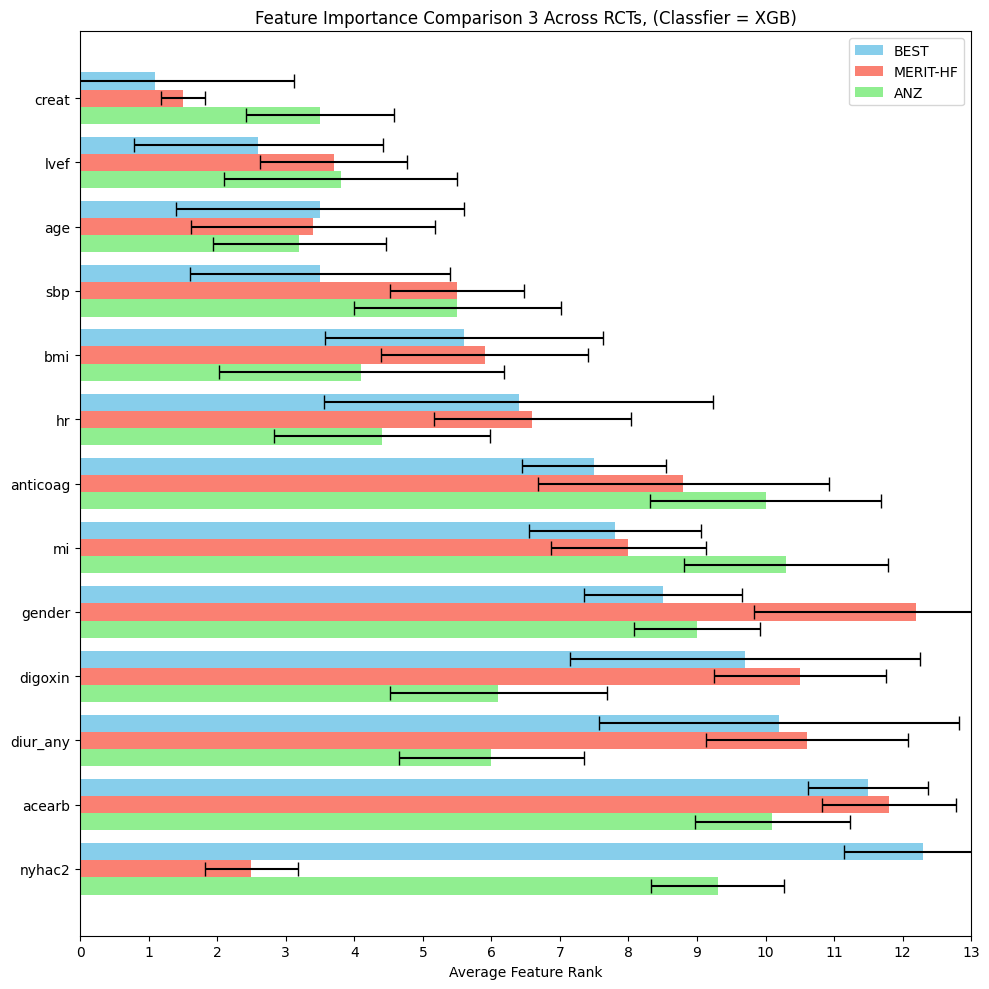

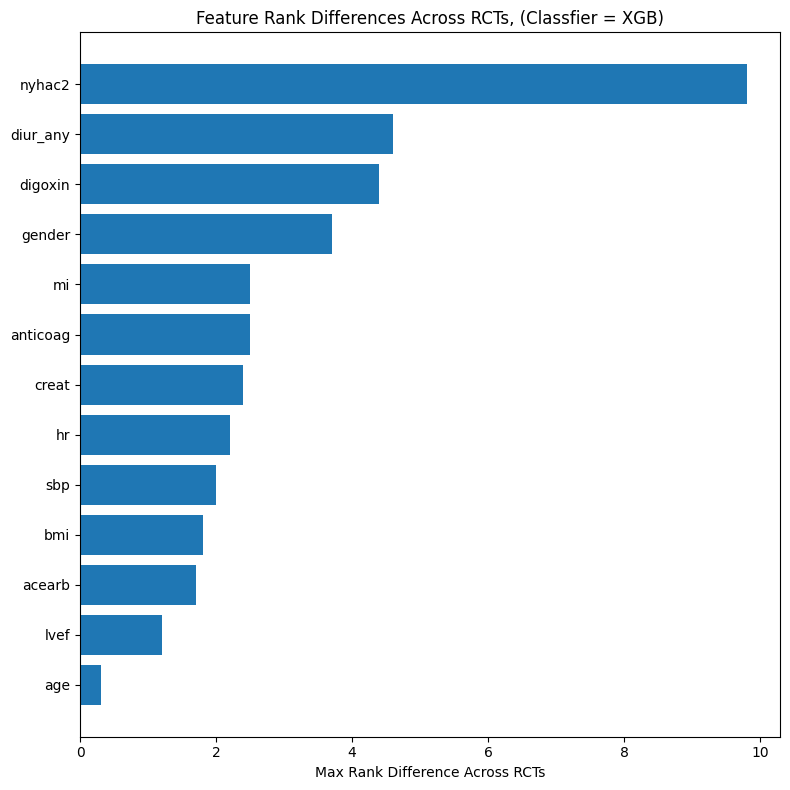

In [19]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from tqdm import tqdm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from functools import reduce

# === Constants ===
target_col = 'severe_outcome'
drop_cols = ['ecgrhyt', 'study', 'upid', target_col]
features_to_transform = ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']
rct_list = ['BEST', 'MERIT-HF', 'ANZ']

# === Preprocessor and pipeline setup ===
preprocessor = ColumnTransformer(transformers=[
    ('qt', QuantileTransformer(output_distribution='normal', n_quantiles=500), features_to_transform)
], remainder='passthrough')

xgb_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(random_state=42))
])

param_grid = {
    'clf__learning_rate': [0.001, 0.005, 0.01, 0.05],
    'clf__max_depth': [2, 3, 4],
    'clf__n_estimators': [800, 1000, 2000],
    'clf__subsample': [0.5, 0.9],
    'clf__colsample_bytree': [0.5, 0.6, 0.7, 0.85, 0.9, 1],
    'clf__min_child_weight': [4, 5, 6, 7, 8],
    'clf__gamma': [0.03, 0.05, 0.07],
    'clf__reg_alpha': [0.1, 0.2, 0.25, 0.3, 0.4],
    'clf__tree_method': ['auto', 'exact', 'approx', 'hist'],
    'clf__eval_metric': ['logloss', 'auc', 'aucpr']
}

# === SHAP ranking function ===
def rank_features_shap(rct_name, n_runs=10):
    rct_df = cleaned_df[cleaned_df['study'] == rct_name].copy()
    feature_rankings = []

    for i in tqdm(range(n_runs), desc=f"Random splits for {rct_name}"):
        train_df, test_df = train_test_split(
            rct_df, test_size=0.5, random_state=i, stratify=rct_df[target_col]
        )

        X_train = train_df.drop(columns=drop_cols)
        y_train = train_df[target_col]
        X_test = test_df.drop(columns=drop_cols)
        y_test = test_df[target_col]

        grid = RandomizedSearchCV(
            estimator=xgb_pipeline,
            param_distributions=param_grid,
            scoring='roc_auc',
            refit=True,
            cv=StratifiedKFold(n_splits=5, shuffle=True),
            n_jobs=-1,
            n_iter=5,
            random_state=i
        )

        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_

        model = best_model.named_steps['clf']
        X_test_transformed = best_model.named_steps['preprocess'].transform(X_test)

        explainer = shap.Explainer(model)
        shap_values = explainer(X_test_transformed)

        mean_shap = np.abs(shap_values.values).mean(axis=0)
        feature_names = best_model.named_steps['preprocess'].get_feature_names_out()

        shap_df = pd.DataFrame({
            'feature': feature_names,
            'rank': pd.Series(mean_shap).rank(ascending=False, method='min').astype(int),
            'run': i,
            'rct': rct_name
        })

        feature_rankings.append(shap_df)

    all_ranks_df = pd.concat(feature_rankings, ignore_index=True)
    all_ranks_df['feature'] = all_ranks_df['feature'].str.replace(r'^(qt__|remainder__)', '', regex=True)

    avg_ranks = all_ranks_df.groupby('feature')['rank'].mean().reset_index()
    avg_ranks.columns = ['feature', f'avg_rank_{rct_name}']
    avg_ranks = avg_ranks.sort_values(f'avg_rank_{rct_name}')

    return avg_ranks, all_ranks_df

# === Run SHAP ranking for all RCTs ===
shap_ranks = {}
all_ranks_data = []

for rct in rct_list:
    avg_rank_df, all_rank_df = rank_features_shap(rct, n_runs=10)
    shap_ranks[rct] = avg_rank_df
    all_ranks_data.append(all_rank_df)

# === Combine all rankings ===
all_ranks_df = pd.concat(all_ranks_data, ignore_index=True)

# === Compute standard deviations ===
rank_std = all_ranks_df.groupby(['rct', 'feature'])['rank'].std().reset_index()
rank_std = rank_std.pivot(index='feature', columns='rct', values='rank').reset_index()
rank_std.columns.name = None
rank_std.columns = ['feature'] + [f'std_rank_{rct}' for rct in rct_list]

# === Merge average ranks and stds ===
merged = reduce(lambda left, right: pd.merge(left, right, on='feature', how='outer'), shap_ranks.values())
merged['feature'] = merged['feature'].str.replace(r'^(qt__|remainder__)', '', regex=True)
merged = merged.merge(rank_std, on='feature', how='left')

# === Compute combined rank difference (max pairwise diff) ===
rank_cols = [f'avg_rank_{rct}' for rct in rct_list]
merged['rank_diff_all'] = merged[rank_cols].max(axis=1) - merged[rank_cols].min(axis=1)

# === Sort by BEST ranks ===
merged = merged.sort_values('avg_rank_BEST')

# === Save all run data ===
all_ranks_df.to_csv("graphs/SHAP/XGB_shap_ranks_per_run_all.csv", index=False)

# === Plot 1: Feature importance comparison across all RCTs ===
y = np.arange(len(merged))
height = 0.8 / len(rct_list)
colors = ['skyblue', 'salmon', 'lightgreen']

plt.figure(figsize=(10, 10))
for idx, rct in enumerate(rct_list):
    plt.barh(
        y - 0.4 + height/2 + idx*height,
        merged[f'avg_rank_{rct}'],
        height,
        xerr=merged[f'std_rank_{rct}'],
        label=rct,
        color=colors[idx % len(colors)],
        capsize=5)

plt.yticks(y, merged['feature'])
plt.gca().invert_yaxis()
plt.xlabel('Average Feature Rank')
plt.title('Feature Importance Comparison 3 Across RCTs, (Classfier = XGB)')
plt.legend()
plt.xlim(1, 13)
plt.xticks(np.arange(0, 14))
plt.tight_layout()
plt.savefig('graphs/SHAP/XGB_shap_rank_comparison.png')
plt.show()

# === Plot: Rank difference among all (sorted by largest difference) ===
merged_sorted_by_diff = merged.sort_values('rank_diff_all', ascending=False)

plt.figure(figsize=(8, 8))
plt.barh(merged_sorted_by_diff['feature'], merged_sorted_by_diff['rank_diff_all'])
plt.xlabel("Max Rank Difference Across RCTs")
plt.title("Feature Rank Differences Across RCTs, (Classfier = XGB)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('graphs/SHAP/XGB_shap_rank_difference.png')
plt.show()

Random splits for BEST:   0%|          | 0/10 [00:00<?, ?it/s]/home/sxa1953/.local/lib/python3.10/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
Random splits for BEST:  10%|█         | 1/10 [00:00<00:03,  2.58it/s]/home/sxa1953/.local/lib/python3.10/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
Random splits for BEST:  20%|██        | 2/10 [00:00<00:01,  4.02it/s]/home/sxa1953/.local/lib/python3.10/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or 

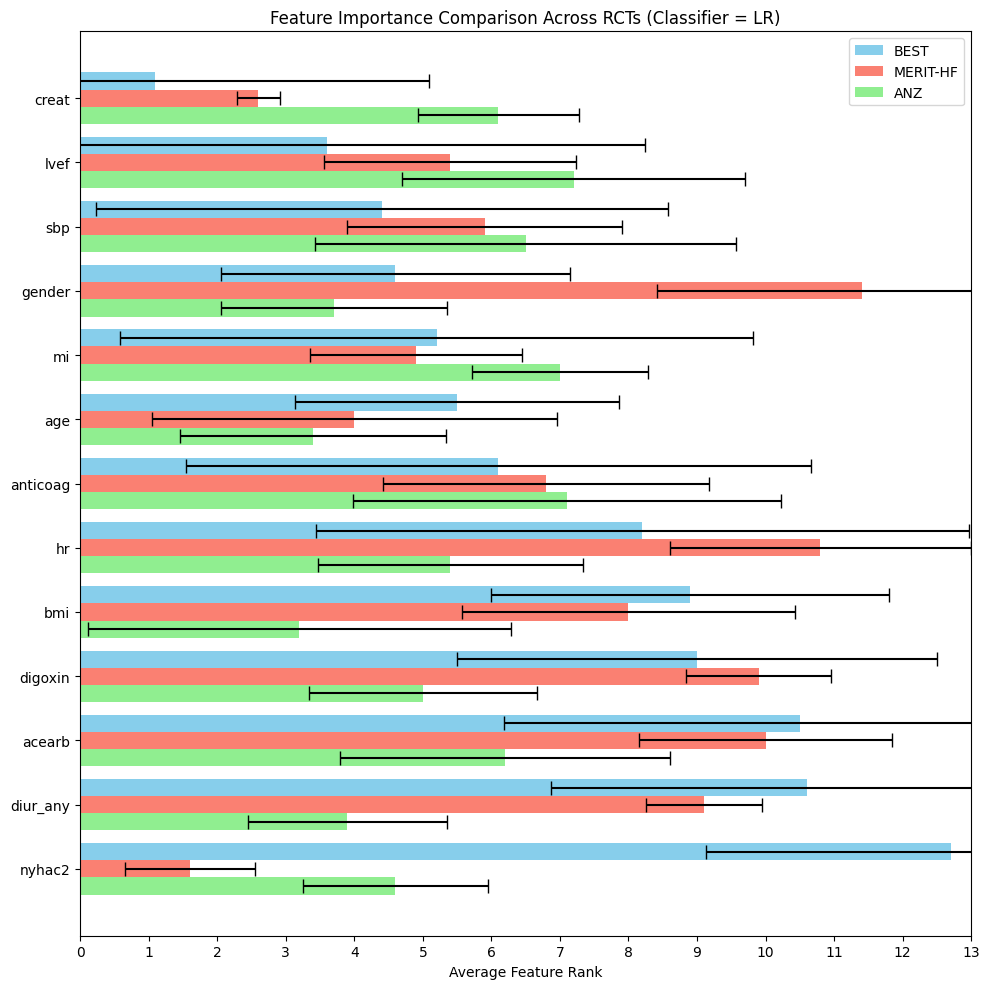

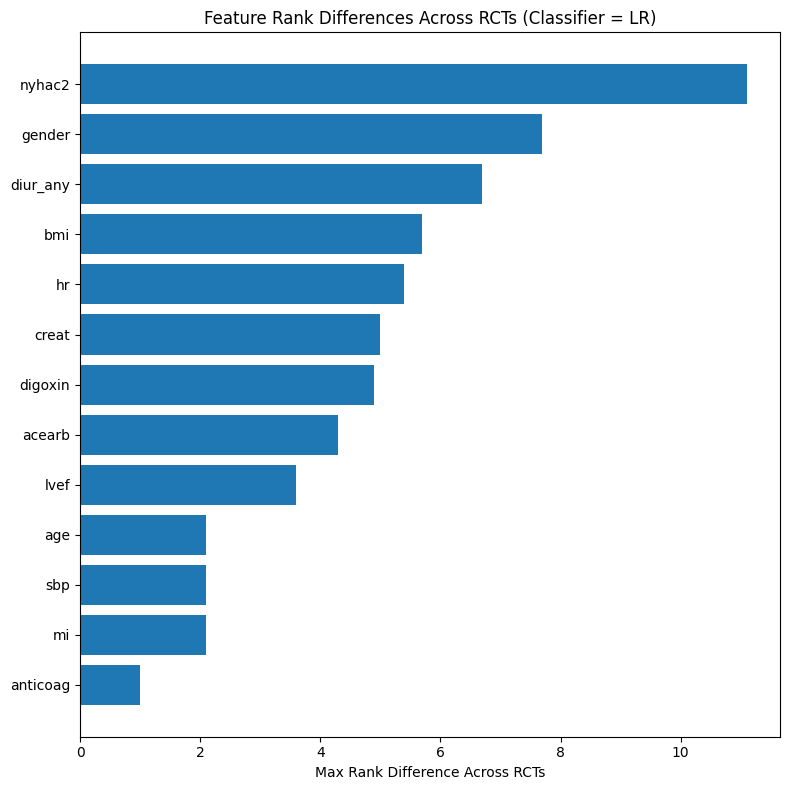

In [25]:
# ========================
# Logistic Regression SHAP Feature Importance Comparison across RCTs
# ========================

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from tqdm import tqdm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from functools import reduce

# === Constants ===
target_col = 'severe_outcome'
drop_cols = ['ecgrhyt', 'study', 'upid', target_col]
features_to_transform = ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']
rct_list = ['BEST', 'MERIT-HF', 'ANZ']

# === Preprocessor & pipeline ===
preprocessor = ColumnTransformer(transformers=[
    ('qt', QuantileTransformer(output_distribution='normal', n_quantiles=500), features_to_transform)
], remainder='passthrough')

logreg_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

# === Hyperparameter grid ===
logreg_param_grid = [
    {
        'clf__penalty': ['l1'],
        'clf__solver': ['liblinear', 'saga'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__max_iter': [800, 1000, 2000],
        'clf__tol': [1e-4, 1e-3, 1e-2],
        'clf__fit_intercept': [True, False],
        'clf__class_weight': [None, 'balanced'],
        'clf__warm_start': [False, True],
    },
    {
        'clf__penalty': ['l2'],
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__max_iter': [800, 1000, 2000],
        'clf__tol': [1e-4, 1e-3, 1e-2],
        'clf__fit_intercept': [True, False],
        'clf__class_weight': [None, 'balanced'],
        'clf__warm_start': [False, True],
    },
    {
        'clf__penalty': ['elasticnet'],
        'clf__solver': ['saga'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__max_iter': [800, 1000, 2000],
        'clf__tol': [1e-4, 1e-3, 1e-2],
        'clf__fit_intercept': [True, False],
        'clf__class_weight': [None, 'balanced'],
        'clf__warm_start': [False, True],
        'clf__l1_ratio': [0.0, 0.1, 0.5, 0.7, 1.0],
    }
]

# === SHAP ranking function ===
def rank_features_shap(rct_name, n_runs=10):
    rct_df = cleaned_df[cleaned_df['study'] == rct_name].copy()
    feature_rankings = []

    for i in tqdm(range(n_runs), desc=f"Random splits for {rct_name}"):
        train_df, test_df = train_test_split(
            rct_df, test_size=0.5, random_state=i, stratify=rct_df[target_col]
        )

        X_train = train_df.drop(columns=drop_cols)
        y_train = train_df[target_col]
        X_test = test_df.drop(columns=drop_cols)
        y_test = test_df[target_col]

        grid = RandomizedSearchCV(
            estimator=logreg_pipeline,
            param_distributions=logreg_param_grid,
            scoring='roc_auc',
            refit=True,
            cv=StratifiedKFold(n_splits=5, shuffle=True),
            n_jobs=-1,
            n_iter=5,
            random_state=i
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_

        # === SHAP for Logistic Regression ===
        model = best_model.named_steps['clf']
        X_test_transformed = best_model.named_steps['preprocess'].transform(X_test)

        explainer = shap.LinearExplainer(model, X_test_transformed, feature_perturbation="interventional")
        shap_values = explainer.shap_values(X_test_transformed)
        mean_shap = np.abs(shap_values).mean(axis=0)

        feature_names = best_model.named_steps['preprocess'].get_feature_names_out()
        shap_df = pd.DataFrame({
            'feature': feature_names,
            'rank': pd.Series(mean_shap).rank(ascending=False, method='min').astype(int),
            'run': i,
            'rct': rct_name
        })

        feature_rankings.append(shap_df)

    all_ranks_df = pd.concat(feature_rankings, ignore_index=True)
    all_ranks_df['feature'] = all_ranks_df['feature'].str.replace(r'^(qt__|remainder__)', '', regex=True)

    avg_ranks = all_ranks_df.groupby('feature')['rank'].mean().reset_index()
    avg_ranks.columns = ['feature', f'avg_rank_{rct_name}']
    avg_ranks = avg_ranks.sort_values(f'avg_rank_{rct_name}')

    return avg_ranks, all_ranks_df

# === Run SHAP ranking for all RCTs ===
shap_ranks = {}
all_ranks_data = []

for rct in rct_list:
    avg_rank_df, all_rank_df = rank_features_shap(rct, n_runs=10)
    shap_ranks[rct] = avg_rank_df
    all_ranks_data.append(all_rank_df)

# === Combine all rankings ===
all_ranks_df = pd.concat(all_ranks_data, ignore_index=True)

# === Compute std deviations ===
rank_std = all_ranks_df.groupby(['rct', 'feature'])['rank'].std().reset_index()
rank_std = rank_std.pivot(index='feature', columns='rct', values='rank').reset_index()
rank_std.columns = ['feature'] + [f'std_rank_{rct}' for rct in rct_list]

# === Merge ===
merged = reduce(lambda left, right: pd.merge(left, right, on='feature', how='outer'), shap_ranks.values())
merged['feature'] = merged['feature'].str.replace(r'^(qt__|remainder__)', '', regex=True)
merged = merged.merge(rank_std, on='feature', how='left')

# === Compute combined rank diff ===
rank_cols = [f'avg_rank_{rct}' for rct in rct_list]
merged['rank_diff_all'] = merged[rank_cols].max(axis=1) - merged[rank_cols].min(axis=1)

# === Sort by BEST ranks ===
merged = merged.sort_values('avg_rank_BEST')

# === Save raw data ===
all_ranks_df.to_csv("graphs/SHAP/LR_shap_ranks_per_run_all.csv", index=False)

# === Plot 1: Feature importance comparison across RCTs ===
y = np.arange(len(merged))
height = 0.8 / len(rct_list)
colors = ['skyblue', 'salmon', 'lightgreen']

plt.figure(figsize=(10, 10))
for idx, rct in enumerate(rct_list):
    plt.barh(
        y - 0.4 + height/2 + idx*height,
        merged[f'avg_rank_{rct}'],
        height,
        xerr=merged[f'std_rank_{rct}'],
        label=rct,
        color=colors[idx % len(colors)],
        capsize=5
    )

plt.yticks(y, merged['feature'])
plt.gca().invert_yaxis()
plt.xlabel('Average Feature Rank')
plt.title('Feature Importance Comparison Across RCTs (Classifier = LR)')
plt.legend()
plt.xlim(1, 13)
plt.xticks(np.arange(0, 14))
plt.tight_layout()
plt.savefig('graphs/SHAP/LR_shap_rank_comparison.png')
plt.show()

# === Plot 2: Rank differences sorted by largest ===
merged_sorted_by_diff = merged.sort_values('rank_diff_all', ascending=False)

plt.figure(figsize=(8, 8))
plt.barh(merged_sorted_by_diff['feature'], merged_sorted_by_diff['rank_diff_all'])
plt.xlabel("Max Rank Difference Across RCTs")
plt.title("Feature Rank Differences Across RCTs (Classifier = LR)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('graphs/SHAP/LR_shap_rank_difference.png')
plt.show()

ANZ: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


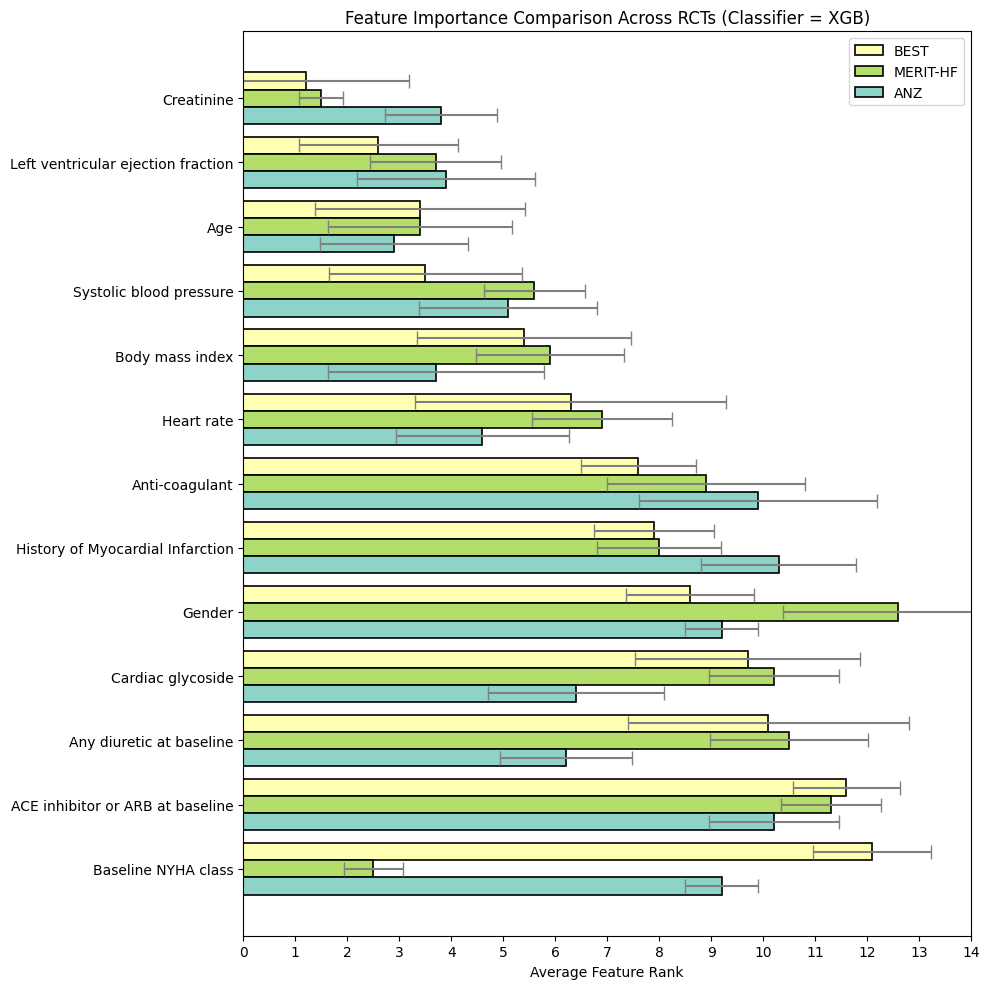

BEST:   0%|          | 0/10 [00:00<?, ?it/s]/home/sxa1953/.local/lib/python3.10/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
BEST:  10%|█         | 1/10 [00:00<00:01,  4.54it/s]/home/sxa1953/.local/lib/python3.10/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
BEST:  20%|██        | 2/10 [00:00<00:01,  5.68it/s]/home/sxa1953/.local/lib/python3.10/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


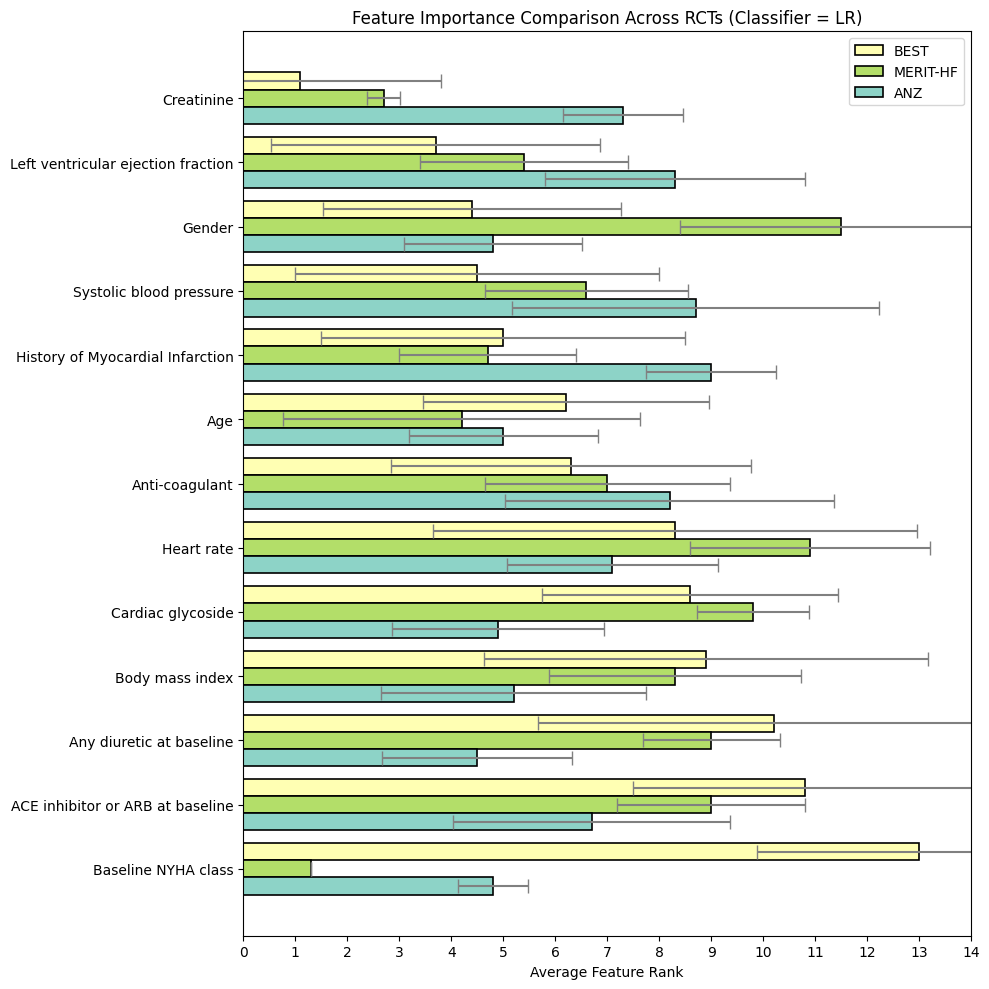

     feature                     feature_display  avg_rank_XGB_mean  \
4      creat                          Creatinine           2.166667   
1        age                                 Age           3.233333   
9       lvef  Left ventricular ejection fraction           3.400000   
12       sbp             Systolic blood pressure           4.733333   
3        bmi                     Body mass index           5.000000   
8         hr                          Heart rate           5.933333   
11    nyhac2                 Baseline NYHA class           7.933333   
10        mi    History of Myocardial Infarction           8.733333   
5    digoxin                   Cardiac glycoside           8.766667   
2   anticoag                      Anti-coagulant           8.800000   
6   diur_any            Any diuretic at baseline           8.933333   
7     gender                              Gender          10.133333   
0     acearb    ACE inhibitor or ARB at baseline          11.033333   

    a

In [33]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tqdm import tqdm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from functools import reduce

# === Constants ===
target_col = 'severe_outcome'
drop_cols = ['ecgrhyt', 'study', 'upid', target_col]
features_to_transform = ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']
rct_list = ['BEST', 'MERIT-HF', 'ANZ']

# === Feature display names ===
feature_display_map = {
    'mi': 'History of Myocardial Infarction',
    'acearb': 'ACE inhibitor or ARB at baseline',
    'diur_any': 'Any diuretic at baseline',
    'nyhac2': 'Baseline NYHA class',
    'sbp': 'Systolic blood pressure',
    'hr': 'Heart rate',
    'lvef': 'Left ventricular ejection fraction',
    'creat': 'Creatinine',
    'anticoag': 'Anti-coagulant',
    'digoxin': 'Cardiac glycoside',
    'bmi': 'Body mass index',
    'age': 'Age',
    'gender': 'Gender',
    'ecgrhyt': 'ECG rhythm'
}

# === Custom color palette based on Set3 with your shades ===
set3_colors = sns.color_palette("Set3")
rct_color_map = {
    'ANZ': set3_colors[0],      # Tiffany blue shade from Set3[0]
    'BEST': set3_colors[1],     # Butter yellow shade from Set3[1]
    'MERIT-HF': set3_colors[6]  # Light green shade from Set3[6]
}


# === Preprocessors ===
preprocessor = ColumnTransformer([
    ('qt', QuantileTransformer(output_distribution='normal', n_quantiles=160), features_to_transform)
], remainder='passthrough')

# === Pipelines ===
xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(random_state=42))
])

logreg_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression())
])

# === Param grids ===
xgb_param_grid = {
    'clf__learning_rate': [0.001, 0.005, 0.01, 0.05],
    'clf__max_depth': [2, 3, 4],
    'clf__n_estimators': [800, 1000, 2000],
    'clf__subsample': [0.5, 0.9],
    'clf__colsample_bytree': [0.5, 0.6, 0.7, 0.85, 0.9, 1],
    'clf__min_child_weight': [4, 5, 6, 7, 8],
    'clf__gamma': [0.03, 0.05, 0.07],
    'clf__reg_alpha': [0.1, 0.2, 0.25, 0.3, 0.4],
    'clf__tree_method': ['auto', 'exact', 'approx', 'hist'],
    'clf__eval_metric': ['logloss', 'auc', 'aucpr']
}

logreg_param_grid = [
    {
        'clf__penalty': ['l1'],
        'clf__solver': ['liblinear', 'saga'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__max_iter': [800, 1000, 2000],
        'clf__tol': [1e-4, 1e-3, 1e-2],
        'clf__fit_intercept': [True, False],
        'clf__class_weight': [None, 'balanced'],
        'clf__warm_start': [False, True],
    },
    {
        'clf__penalty': ['l2'],
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__max_iter': [800, 1000, 2000],
        'clf__tol': [1e-4, 1e-3, 1e-2],
        'clf__fit_intercept': [True, False],
        'clf__class_weight': [None, 'balanced'],
        'clf__warm_start': [False, True],
    },
    {
        'clf__penalty': ['elasticnet'],
        'clf__solver': ['saga'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__max_iter': [800, 1000, 2000],
        'clf__tol': [1e-4, 1e-3, 1e-2],
        'clf__fit_intercept': [True, False],
        'clf__class_weight': [None, 'balanced'],
        'clf__warm_start': [False, True],
        'clf__l1_ratio': [0.0, 0.1, 0.5, 0.7, 1.0],
    }
]

# === SHAP ranking function ===
def rank_features_shap(model_pipeline, param_grid, rct_name, n_runs=10, use_linear=False):
    rct_df = cleaned_df[cleaned_df['study'] == rct_name].copy()
    feature_rankings = []

    for i in tqdm(range(n_runs), desc=f"{rct_name}"):
        train_df, test_df = train_test_split(
            rct_df, test_size=0.5, random_state=i, stratify=rct_df[target_col]
        )

        X_train = train_df.drop(columns=drop_cols)
        y_train = train_df[target_col]
        X_test = test_df.drop(columns=drop_cols)
        y_test = test_df[target_col]

        grid = RandomizedSearchCV(
            estimator=model_pipeline,
            param_distributions=param_grid,
            scoring='roc_auc',
            refit=True,
            cv=StratifiedKFold(n_splits=5, shuffle=True),
            n_jobs=-1,
            n_iter=5,
            random_state=i
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        model = best_model.named_steps['clf']
        X_test_trans = best_model.named_steps['preprocess'].transform(X_test)

        # SHAP
        if use_linear:
            explainer = shap.LinearExplainer(model, X_test_trans, feature_perturbation="interventional")
            shap_values = explainer.shap_values(X_test_trans)
        else:
            explainer = shap.Explainer(model)
            shap_values = explainer(X_test_trans).values

        mean_shap = np.abs(shap_values).mean(axis=0)
        feature_names = best_model.named_steps['preprocess'].get_feature_names_out()
        shap_df = pd.DataFrame({
            'feature': feature_names,
            'rank': pd.Series(mean_shap).rank(ascending=False, method='min').astype(int),
            'run': i,
            'rct': rct_name
        })
        feature_rankings.append(shap_df)

    all_ranks_df = pd.concat(feature_rankings, ignore_index=True)
    all_ranks_df['feature'] = all_ranks_df['feature'].str.replace(r'^(qt__|remainder__)', '', regex=True)

    avg_ranks = all_ranks_df.groupby('feature')['rank'].mean().reset_index()
    avg_ranks.columns = ['feature', f'avg_rank_{rct_name}']
    avg_ranks = avg_ranks.sort_values(f'avg_rank_{rct_name}')

    return avg_ranks, all_ranks_df

# === Run for both classifiers ===

merged_dfs = {}  # To store merged dfs by clf_name

for clf_name, pipeline, param_grid, use_linear in [
    ("XGB", xgb_pipeline, xgb_param_grid, False),
    ("LR", logreg_pipeline, logreg_param_grid, True)
]:
    shap_ranks = {}
    all_ranks_data = []

    for rct in rct_list:
        avg_rank_df, all_rank_df = rank_features_shap(pipeline, param_grid, rct, n_runs=10, use_linear=use_linear)
        shap_ranks[rct] = avg_rank_df
        all_ranks_data.append(all_rank_df)

    all_ranks_df = pd.concat(all_ranks_data, ignore_index=True)

    rank_std = all_ranks_df.groupby(['rct', 'feature'])['rank'].std().reset_index()
    rank_std = rank_std.pivot(index='feature', columns='rct', values='rank').reset_index()
    rank_std.columns = ['feature'] + [f'std_rank_{rct}' for rct in rct_list]

    merged = reduce(lambda l, r: pd.merge(l, r, on='feature', how='outer'), shap_ranks.values())
    merged['feature'] = merged['feature'].str.replace(r'^(qt__|remainder__)', '', regex=True)
    merged = merged.merge(rank_std, on='feature', how='left')
    merged = merged.sort_values('avg_rank_BEST')

    # Map to display names
    merged['feature_display'] = merged['feature'].map(feature_display_map).fillna(merged['feature'])

    all_ranks_df.to_csv(f"graphs/SHAP/{clf_name}_shap_ranks_per_run_all.csv", index=False)

    # Save merged df for summary
    merged_dfs[clf_name] = merged

    # === Plot ===
    sns.set_palette([rct_color_map[rct] for rct in rct_list])
    y = np.arange(len(merged))
    height = 0.8 / len(rct_list)

    plt.figure(figsize=(10, 10))
    for idx, rct in enumerate(rct_list):
        plt.barh(
            y - 0.4 + height/2 + idx*height,
            merged[f'avg_rank_{rct}'],
            height,
            xerr=merged[f'std_rank_{rct}'],
            label=rct,
            color=rct_color_map[rct],
            edgecolor='black',
            linewidth=1.2,
            capsize=5,
            ecolor='grey'
        )

    plt.yticks(y, merged['feature_display'])
    plt.gca().invert_yaxis()
    plt.xlabel('Average Feature Rank')
    plt.title(f'Feature Importance Comparison Across RCTs (Classifier = {clf_name})')
    plt.legend()
    plt.xlim(0, 14)
    plt.xticks(np.arange(0, 15, 1))
    plt.tight_layout()
    plt.savefig(f'graphs/SHAP/{clf_name}_shap_rank_comparison_custom_palette.png')
    plt.show()

# === Create summary table across classifiers ===
def create_summary_table(merged_df, clf_name):
    avg_cols = [col for col in merged_df.columns if col.startswith('avg_rank_')]
    # Calculate mean avg rank across RCTs
    merged_df[f'avg_rank_{clf_name}_mean'] = merged_df[avg_cols].mean(axis=1)
    # Calculate difference between max and min avg rank per feature
    merged_df[f'avg_rank_{clf_name}_diff'] = merged_df[avg_cols].max(axis=1) - merged_df[avg_cols].min(axis=1)
    return merged_df[['feature', 'feature_display', f'avg_rank_{clf_name}_mean', f'avg_rank_{clf_name}_diff']]

summary_xgb = create_summary_table(merged_dfs['XGB'], 'XGB')
summary_lr = create_summary_table(merged_dfs['LR'], 'LR')

# Merge the summaries on feature and feature_display
summary_all = summary_xgb.merge(summary_lr, on=['feature', 'feature_display'], how='outer')

# Sort by XGB mean avg rank for display
summary_all = summary_all.sort_values('avg_rank_XGB_mean')

# Save summary table
summary_all.to_csv("graphs/SHAP/summary_feature_importance_across_models.csv", index=False)

# Display summary table
print(summary_all)


In [39]:
# For XGB
xgb_df = merged_dfs['XGB'][['feature_display', 'avg_rank_BEST', 'avg_rank_MERIT-HF', 'avg_rank_ANZ']].copy()

# Calculate range (max-min) across RCTs
xgb_df['rank_range'] = xgb_df[['avg_rank_BEST', 'avg_rank_MERIT-HF', 'avg_rank_ANZ']].max(axis=1) - \
                       xgb_df[['avg_rank_BEST', 'avg_rank_MERIT-HF', 'avg_rank_ANZ']].min(axis=1)

# Sort by average rank across trials for more intuitive viewing
xgb_df['avg_rank_overall'] = xgb_df[['avg_rank_BEST', 'avg_rank_MERIT-HF', 'avg_rank_ANZ']].mean(axis=1)
xgb_df = xgb_df.sort_values('avg_rank_overall')

# Drop helper col
xgb_df = xgb_df.drop(columns=['avg_rank_overall'])

# Display
print(xgb_df.to_string(index=False))


                   feature_display  avg_rank_BEST  avg_rank_MERIT-HF  avg_rank_ANZ  rank_range
                        Creatinine            1.2                1.5           3.8         2.6
                               Age            3.4                3.4           2.9         0.5
Left ventricular ejection fraction            2.6                3.7           3.9         1.3
           Systolic blood pressure            3.5                5.6           5.1         2.1
                   Body mass index            5.4                5.9           3.7         2.2
                        Heart rate            6.3                6.9           4.6         2.3
               Baseline NYHA class           12.1                2.5           9.2         9.6
  History of Myocardial Infarction            7.9                8.0          10.3         2.4
                 Cardiac glycoside            9.7               10.2           6.4         3.8
                    Anti-coagulant            7.6 

In [40]:
xgb_df

,feature_display,avg_rank_BEST,avg_rank_MERIT-HF,avg_rank_ANZ,rank_range
4,Creatinine,1.2,1.5,3.8,2.6
1,Age,3.4,3.4,2.9,0.5
9,Left ventricular ejection fraction,2.6,3.7,3.9,1.3
12,Systolic blood pressure,3.5,5.6,5.1,2.1
3,Body mass index,5.4,5.9,3.7,2.2
8,Heart rate,6.3,6.9,4.6,2.3
11,Baseline NYHA class,12.1,2.5,9.2,9.6
10,History of Myocardial Infarction,7.9,8.0,10.3,2.4
5,Cardiac glycoside,9.7,10.2,6.4,3.8
2,Anti-coagulant,7.6,8.9,9.9,2.3


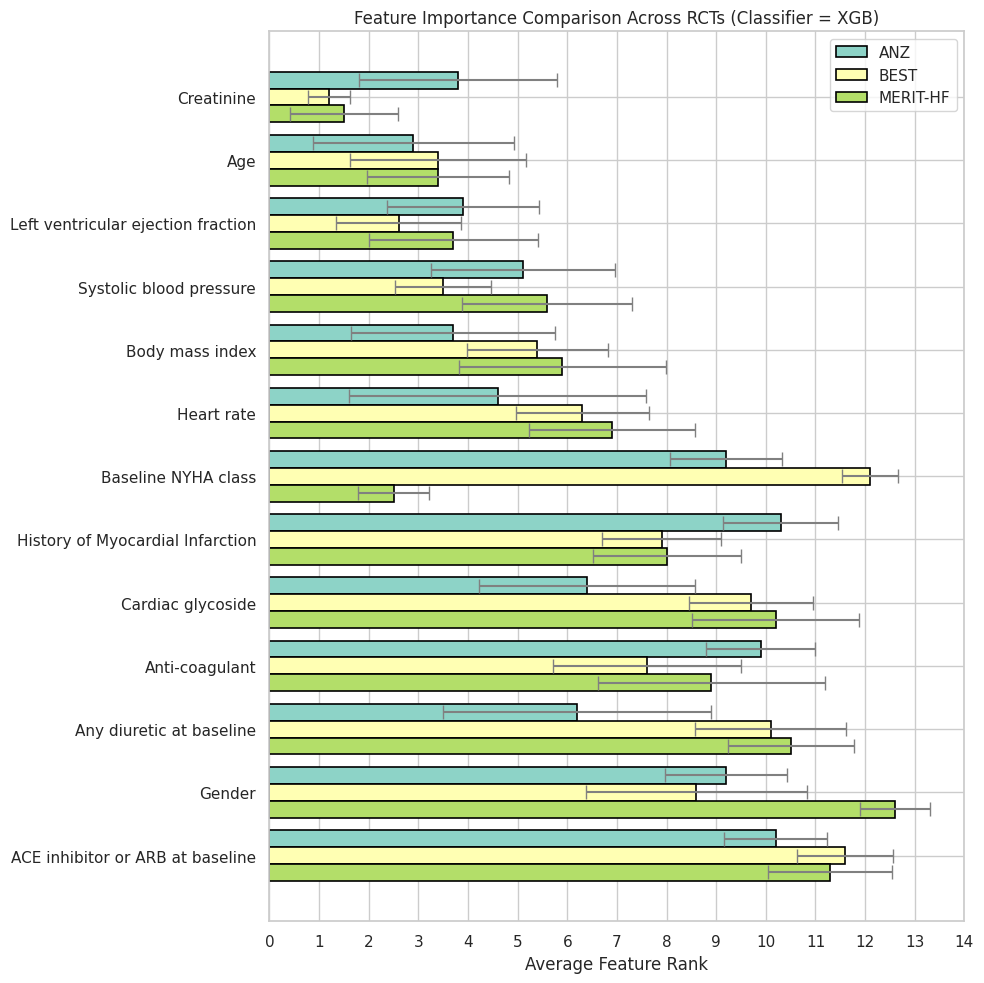

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Inputs ===
model_name = "XGB"  # or "LR"
csv_path = f"graphs/SHAP/{model_name}_shap_ranks_per_run_all.csv"

# === Load Data ===
df = pd.read_csv(csv_path)

# === Feature display map ===
feature_display_map = {
    'mi': 'History of Myocardial Infarction',
    'acearb': 'ACE inhibitor or ARB at baseline',
    'diur_any': 'Any diuretic at baseline',
    'nyhac2': 'Baseline NYHA class',
    'sbp': 'Systolic blood pressure',
    'hr': 'Heart rate',
    'lvef': 'Left ventricular ejection fraction',
    'creat': 'Creatinine',
    'anticoag': 'Anti-coagulant',
    'digoxin': 'Cardiac glycoside',
    'bmi': 'Body mass index',
    'age': 'Age',
    'gender': 'Gender',
    'ecgrhyt': 'ECG rhythm'
}

# === Color palette (Set3 style) ===
set3_colors = sns.color_palette("Set3")
rct_color_map = {
    'ANZ': set3_colors[0],
    'BEST': set3_colors[1],
    'MERIT-HF': set3_colors[6]
}
rct_list = list(rct_color_map.keys())

# === Compute avg + std rank ===
grouped = df.groupby(['rct', 'feature'])['rank'].agg(['mean', 'std']).reset_index()
grouped['feature_display'] = grouped['feature'].map(feature_display_map).fillna(grouped['feature'])

# === Pivot for plotting ===
avg_rank_pivot = grouped.pivot(index='feature_display', columns='rct', values='mean')
std_rank_pivot = grouped.pivot(index='feature_display', columns='rct', values='std')

# === Sort by BEST RCT or mean across RCTs ===
sort_col = 'BEST' if 'BEST' in avg_rank_pivot.columns else avg_rank_pivot.mean(axis=1)
sorted_features = avg_rank_pivot.loc[:, rct_list].mean(axis=1).sort_values().index

# === Plot ===
sns.set_palette([rct_color_map[rct] for rct in rct_list])
y = np.arange(len(sorted_features))
height = 0.8 / len(rct_list)

plt.figure(figsize=(10, 10))
for idx, rct in enumerate(rct_list):
    plt.barh(
        y - 0.4 + height/2 + idx*height,
        avg_rank_pivot.loc[sorted_features, rct],
        height,
        xerr=std_rank_pivot.loc[sorted_features, rct],
        label=rct,
        color=rct_color_map[rct],
        edgecolor='black',
        linewidth=1.2,
        capsize=5,
        ecolor='grey'
    )

plt.yticks(y, sorted_features)
plt.gca().invert_yaxis()
plt.xlabel('Average Feature Rank')
plt.title(f'Feature Importance Comparison Across RCTs (Classifier = {model_name})')
plt.legend()
plt.xlim(0, 14)
plt.xticks(np.arange(0, 15, 1))
plt.tight_layout()
plt.savefig(f'graphs/SHAP/{model_name}_shap_rank_comparison_custom_palette_replot.pdf', dpi=600)
plt.show()


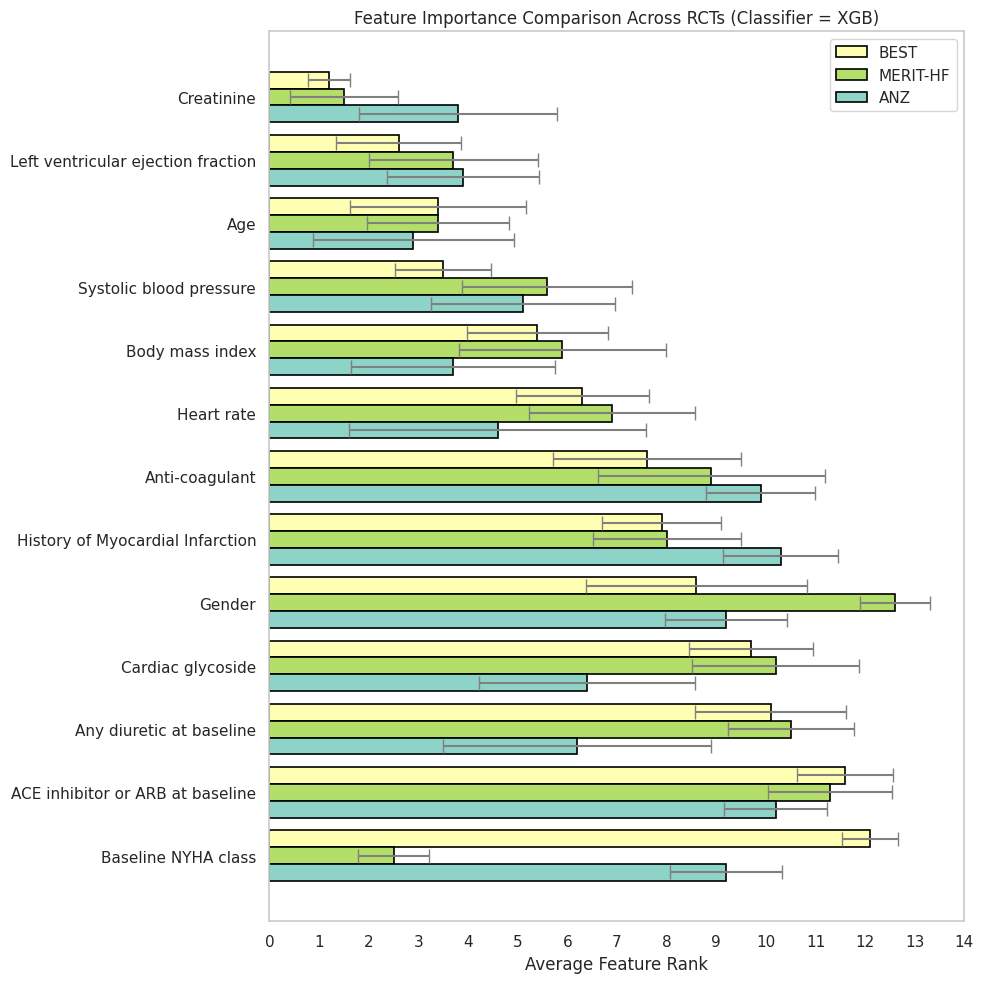

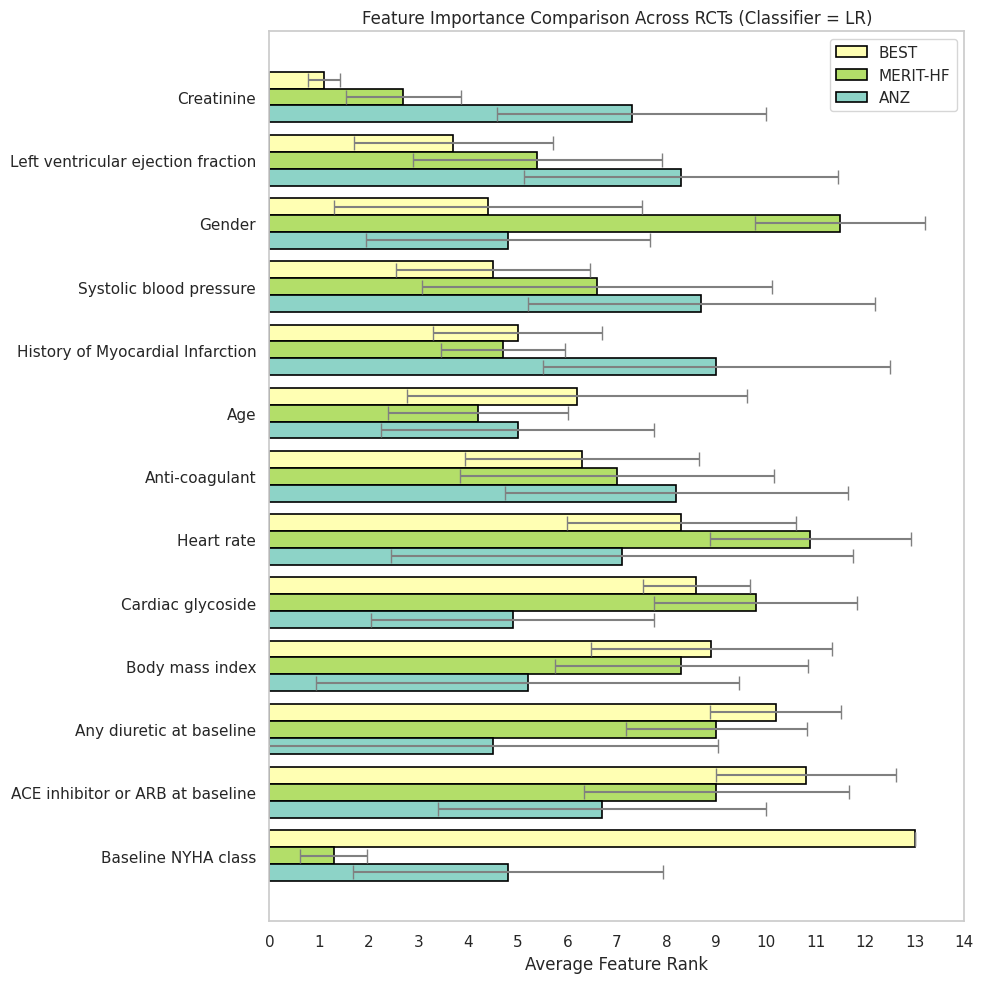

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Display name mapping (adjust as needed) ===
feature_display_map = {
    'mi': 'History of Myocardial Infarction',
    'acearb': 'ACE inhibitor or ARB at baseline',
    'diur_any': 'Any diuretic at baseline',
    'nyhac2': 'Baseline NYHA class',
    'sbp': 'Systolic blood pressure',
    'hr': 'Heart rate',
    'lvef': 'Left ventricular ejection fraction',
    'creat': 'Creatinine',
    'anticoag': 'Anti-coagulant',
    'digoxin': 'Cardiac glycoside',
    'bmi': 'Body mass index',
    'age': 'Age',
    'gender': 'Gender',
    'ecgrhyt': 'ECG rhythm'
}

# === RCTs in desired display order ===
rct_list_ordered = ['BEST', 'MERIT-HF', 'ANZ']

# === Custom color palette ===
set3_colors = sns.color_palette("Set3")
rct_color_map = {
    'ANZ': set3_colors[0],
    'BEST': set3_colors[1],
    'MERIT-HF': set3_colors[6]
}
rct_colors = [rct_color_map[rct] for rct in rct_list_ordered]

# === Load and plot for each model ===
for model_name in ['XGB', 'LR']:
    df = pd.read_csv(f'graphs/SHAP/{model_name}_shap_ranks_per_run_all.csv')

    # Clean feature names
    df['feature'] = df['feature'].str.replace(r'^(qt__|remainder__)', '', regex=True)

    # Add readable feature names
    df['feature_display'] = df['feature'].map(feature_display_map).fillna(df['feature'])

    # Average and std dev of rank
    grouped = df.groupby(['feature_display', 'rct'])['rank'].agg(['mean', 'std']).reset_index()

    # Pivot for plotting
    avg_rank_pivot = grouped.pivot(index='feature_display', columns='rct', values='mean')
    std_rank_pivot = grouped.pivot(index='feature_display', columns='rct', values='std')

    # Sort by BEST ranking
    sorted_features = avg_rank_pivot.sort_values('BEST').index.tolist()

    # === Plotting ===
    sns.set_palette(rct_colors)
    plt.figure(figsize=(10, 10))
    y = np.arange(len(sorted_features))
    height = 0.8 / len(rct_list_ordered)

    for idx, rct in enumerate(rct_list_ordered):
        plt.barh(
            y - 0.4 + height/2 + idx * height,
            avg_rank_pivot[rct].reindex(sorted_features),
            height,
            xerr=std_rank_pivot[rct].reindex(sorted_features),
            label=rct,
            color=rct_color_map[rct],
            edgecolor='black',
            linewidth=1.2,
            capsize=5,
            ecolor='grey'
        )

    plt.yticks(y, sorted_features)
    plt.gca().invert_yaxis()
    plt.xlabel('Average Feature Rank')
    plt.title(f'Feature Importance Comparison Across RCTs (Classifier = {model_name})')
    plt.legend()
    plt.xlim(0, 14)
    plt.xticks(np.arange(0, 15, 1))
    plt.grid(False)  # Remove background grid
    plt.tight_layout()
    plt.savefig(f'graphs/SHAP/{model_name}_shap_rank_comparison_custom_palette_ordered.pdf', dpi=600)
    plt.show()
